In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy as sc
import scipy.io as scio
import scipy.ndimage as scimg
import scipy.integrate as scint
import sys
sys.path.append('/cds/home/s/siqili/vNrecon/code')
import vNfunctions as vN
import numpy.matlib as npmat
import h5py
from scipy.optimize import fmin
from scipy.optimize import check_grad
from scipy.optimize import fmin_bfgs
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import median_filter as mf
import warnings
warnings.filterwarnings('ignore')

In [2]:
#function to smooth vls
# %Copyright (c) 2012, Thomas C. O'Haver
# % 
# % Permission is hereby granted, free of charge, to any person obtaining a copy
# % of this software and associated documentation files (the "Software"), to deal
# % in the Software without restriction, including without limitation the rights
# % to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# % copies of the Software, and to permit persons to whom the Software is
# % furnished to do so, subject to the following conditions:
# % 
# % The above copyright notice and this permission notice shall be included in
# % all copies or substantial portions of the Software.
# % 
# % THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# % IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# % FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# % AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# % LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# % OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# % THE SOFTWARE.

def sa(Y,smoothwidth):
    w=int(smoothwidth + 0.5)
    SumPoints=np.nansum(Y[0:w])
    s=np.zeros(len(Y)) + SumPoints
    halfw=int(w/2 + 0.5)

    L=len(Y)
    for k in np.arange(0,L-w): 
        if k+halfw+1 < L-w:
            s[k+halfw+1]=SumPoints
        SumPoints=SumPoints-Y[k]
        SumPoints=SumPoints+Y[k+w]
    s[L-w-1:L]= s[L-w-1] - Y[L-w-1] + Y[L-w-1+halfw] #np.nansum(Y[L-w+halfw:L])
    SmoothY=s/w
    return SmoothY

def fastsmooth1(Y,w):
    SmoothY=sa(Y,w);
    return SmoothY

In [3]:
#read streaked spectrum
vls_all=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/data/streaked_vls_run_286.npy')
spec_data=np.zeros(np.shape(vls_all))

In [4]:
#vls calibration
def px_2_nm(pixel, vls_pitch, order):
    'updated May 8/9 from Dougie'
    pitch_slope = -1.37220068e+03 # negative of pitch shift to px shift proportionality constant
    pitch_0 = 4.98 #The VLS pitch where the calibration is done 
    order_0 = 4
    pitch_diff = pitch_0-vls_pitch
    effective_pixel = pixel + (pitch_slope*pitch_diff)
    # Result of calibration at pitch_0
    #offset, slope = [ 2.37772901e+00, -3.64235449e-04]
    offset, slope, slope_2 =[ 2.38324323e+00, -3.92516982e-04,  1.44317419e-08]
    return (offset + slope*effective_pixel + slope_2*effective_pixel**2)*(order_0/order)

def eV(wavelen):
    'wavelen in nm'
    return 1e2 * 6.64 * 2.99 / (wavelen * 1.6)

In [5]:
vls_nm=px_2_nm(np.arange(500), 6, 1)
vls_eV=eV(vls_nm)
print(vls_eV[0],vls_eV[-1])
pixperev=500.0/(vls_eV[-1]-vls_eV[0])
pixperev

166.59007184857188 183.55582048324223


29.47114275748641

In [9]:
#vls processing: smothing and background subtraction
for j in range(len(vls_all)):
    spec = np.squeeze(fastsmooth1(vls_all[j,:],20))
    spec = np.array(np.squeeze(spec) - np.mean(np.squeeze(spec)[0:100])) 
    spec_data[j,:]=spec
    # plt.plot(vls_all[j,:])
    # plt.plot(spec)

In [10]:
spec_data=spec_data[:,0:1024]

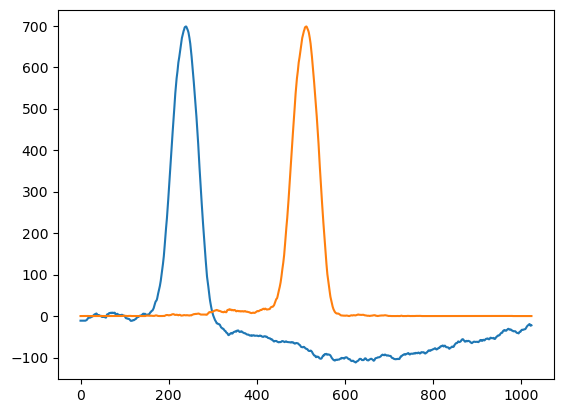

In [11]:
spec_data2=np.roll(spec_data,512-np.argmax(np.mean(spec_data,0)),axis=1)
spec_data2[spec_data2<0]=0
plt.plot(np.mean(spec_data,0))
plt.plot(np.mean(spec_data2,0))

In [12]:
#save processed vls spectrum
# np.save('/reg/d/psdm/tmo/tmoc00118/results/siqili/data/streaked_vls_processed_run_286.npy',spec_data2)
